In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'car-object-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F843852%2F3866417%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240915%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240915T005653Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6fde46314c682d8037f1d760069e88c7371e9e73cb05a71aca4c2d8f50726aeb2dab7ccfdb16093690dbdee389930f279cde14edf0394f8b0412327f82e5b389492cf504ffb9105b020a583528627416f2c3a3b37e34473073d53e7eae0970b96168f799086fac2f2d27180e134a0485c790bbb9edcf5e6694c4d405884514c725aaf3d54edf9264b31430b4c1674b1ad388f045f4b289d8ea604bd3339d7139735110b0f363b1031b7ab05cbadc39be3ef6df9d9094b076dc11ac25590142806eadc351c0aa9eb12eca90915f3200107c366d7278ee6b94c03c49372ac1700973fdcd71776ed1485299ff760b8bfe158bfc6291c943c69e05d5173fb448ca1f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 117507383 bytes downloaded
Downloaded and uncompressed: car-object-detection
Data source import complete.


# <b>1 <span style ='color:#0386f7de'>|</span> Importing Libraries</b>


In [2]:
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.model_selection import train_test_split

# <b>2 <span style ='color:#0386f7de'>|</span> Loading the data</b>

In [3]:
IMG_ROOT = '/kaggle/input/car-object-detection/data/training_images'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
df =pd.read_csv('/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df = df.rename(columns={'image' : 'ImageID'})
df

,ImageID,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


In [4]:
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

(501, 58)

In [5]:
label2target = {'background': 0 , 'car' : 1  }
target2label = { t: l for l,t in  label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [6]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

def find(files_path):
    file_path_dict = {}
    for file_path in files_path:
        file_path_dict[file_path.split('/')[-1]] = file_path

    return file_path_dict

In [7]:
class OpenDataset(Dataset):
    def __init__(self, df, image_dir):
        self.w, self.h = 224, 224
        self.image_dir = image_dir
        self.files = glob.glob( self.image_dir + '/*' )
        self.df = df.copy()
        self.image_infos = df.ImageID.unique()
        self.find_image_path = find(self.files)

    def __getitem__(self, ix):
        image_id = self.image_infos[ix]
        img_path = self.find_image_path[image_id]
        img = Image.open(img_path).convert("RGB")
        data = self.df[self.df['ImageID'] == image_id]
        H, W , _ = np.array(img).shape
        # Normalise the dimension of the bounding boxes and dimensions of image
        data.loc[:, ['xmin', 'ymin', 'xmax', 'ymax']] /= [W, H, W, H]
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        labels = ['car'] * len(data)
        data = data[['xmin','ymin','xmax','ymax']].values
        # Regenerate the dimension of the bounding boxes of the new size (224,224)
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist()
        target = {}

        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()

        img = preprocess_image(img)
        return img, target
    def collate_fn(self, batch):
        """ Takes a batch of data and rearranges it into a format suitable for processing. """


        # - *batch : syntax unpacks the list batch so that each tuple in the list is passed as a separate argument to zip.
        # - zip : then aggregates elements from each of these tuples. The first elements of all tuples in the batch are grouped together
        # the second elements are grouped together, and so on.
        # - tuple(zip(*batch)) : This converts the output of zip (which is an iterator of tuples) back into a tuple.
        # batch = [
        #    (image1, label1),
        #    (image2, label2),
        #    (image3, label3)
        # ]
        # tuple(zip(*batch)) -> ((image1, image2, image3), (label1, label2, label3))

        return tuple(zip(*batch))

    def __len__(self):
        return len(self.image_infos)

In [8]:
%%time
train_ds = OpenDataset(trn_df, IMG_ROOT)
test_ds = OpenDataset(val_df , IMG_ROOT)

train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)
# For example, reduce to 3% of the dataset size
trn_df = trn_df.sample(frac=0.3, random_state=99)
val_df = val_df.sample(frac=0.3, random_state=99)

CPU times: user 13.3 ms, sys: 947 µs, total: 14.2 ms
Wall time: 14.5 ms


# <b>3 <span style ='color:#0386f7de'>|</span> Building the model</b>

In [9]:

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2()
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features # number of input channels
                                                    , num_classes)

# <b>4 <span style ='color:#0386f7de'>|</span> Training the model</b>


In [10]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method
    #and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [11]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,
                             weight_decay=0.0005)

In [12]:
# Reduce the dataset size by sampling a fraction of it
# For example, reduce to 10% of the dataset size
trn_df = trn_df.sample(frac=0.1, random_state=99)
val_df = val_df.sample(frac=0.1, random_state=99)

print(f"Reduced training dataframe size: {len(trn_df)}")
print(f"Reduced validation dataframe size: {len(val_df)}")

train_ds = OpenDataset(trn_df, IMG_ROOT)
test_ds = OpenDataset(val_df , IMG_ROOT)

print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(test_ds)}")

train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)


Reduced training dataframe size: 15
Reduced validation dataframe size: 2
Training dataset size: 15
Validation dataset size: 2


In [13]:
n_epochs = 10
best_valid_loss = float("inf")
patience = 4  # Number of epochs to wait for improvement
patience_counter = 0

for epoch in range(n_epochs):
    _n = len(train_loader)

    for ix, inputs in enumerate(train_loader):

        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
                [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        pos = (epoch + (ix + 1) / _n)

            # Print training loss details
    print(f"Epoch {epoch + 1}/{n_epochs}, "
                  f"Loss: {loss.item():.4f}, "
                  f"Loc Loss: {loc_loss.item():.4f}, "
                  f"Regr Loss: {regr_loss.item():.4f}, "
                  f"Objectness Loss: {loss_objectness.item():.4f}, "
                  f"RPN Box Reg Loss: {loss_rpn_box_reg.item():.4f}", end='\n')



    _n = len(test_loader)
    for ix, inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        pos = (epoch + (ix + 1) / _n)

    # Save the best model
    if loss < best_valid_loss:
        best_valid_loss = loss
        torch.save(model.state_dict(), "tut2-model.pt")
        patience_counter = 0  # Reset the patience counter if validation loss improves
    else:
        patience_counter += 1

        # Print validation loss details
    print(f'Epoch {epoch + 1}/{n_epochs},\n '
              f"Val Loss: {loss.item():.4f},\n "
              f"Val Loc Loss: {loc_loss.item():.4f},\n "
              f"Val Regr Loss: {regr_loss.item():.4f},\n "
              f"Val Objectness Loss: {loss_objectness.item():.4f},\n "
              f"Val RPN Box Reg Loss: {loss_rpn_box_reg.item():.4f}", end='\n')

    if patience_counter >= patience:
        print("\nEarly stopping triggered")
        break


model.load_state_dict(torch.load("tut2-model.pt"))

Epoch 1/10, Loss: 0.6798, Loc Loss: 0.0610, Regr Loss: 0.0071, Objectness Loss: 0.6060, RPN Box Reg Loss: 0.0057
Epoch 1/10,
 Val Loss: 0.6224,
 Val Loc Loss: 0.0358,
 Val Regr Loss: 0.0017,
 Val Objectness Loss: 0.5817,
 Val RPN Box Reg Loss: 0.0032
Epoch 2/10, Loss: 0.4475, Loc Loss: 0.0480, Regr Loss: 0.0065, Objectness Loss: 0.3873, RPN Box Reg Loss: 0.0057
Epoch 2/10,
 Val Loss: 0.3934,
 Val Loc Loss: 0.0462,
 Val Regr Loss: 0.0034,
 Val Objectness Loss: 0.3411,
 Val RPN Box Reg Loss: 0.0028
Epoch 3/10, Loss: 0.2810, Loc Loss: 0.1151, Regr Loss: 0.0259, Objectness Loss: 0.1346, RPN Box Reg Loss: 0.0054
Epoch 3/10,
 Val Loss: 0.5366,
 Val Loc Loss: 0.3431,
 Val Regr Loss: 0.0683,
 Val Objectness Loss: 0.1226,
 Val RPN Box Reg Loss: 0.0025
Epoch 4/10, Loss: 0.1567, Loc Loss: 0.0714, Regr Loss: 0.0333, Objectness Loss: 0.0471, RPN Box Reg Loss: 0.0049
Epoch 4/10,
 Val Loss: 0.2464,
 Val Loc Loss: 0.1243,
 Val Regr Loss: 0.0707,
 Val Objectness Loss: 0.0490,
 Val RPN Box Reg Loss: 0.0

<ipython-input-13-0aa84f9b43cf>:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("tut2-model.pt"))


<All keys matched successfully>

# <b>5 <span style ='color:#0386f7de'>|</span> Model results</b>

In [14]:
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

In [15]:
def plot_bbs_confs_labels(image, bbs, confs, labels, label_colors=None):
    """
    Plot bounding boxes, confidence scores, and labels on an image.

    Parameters:
    - image: The image on which to plot (numpy array).
    - bbs: List of bounding boxes, each in the form [x, y, width, height].
    - confs: List of confidence scores for each bounding box.
    - labels: List of labels for each bounding box.
    - label_colors: Optional dictionary mapping labels to colors.

    Returns:
    - Image with bounding boxes, confidence scores, and labels plotted.
    """
    image_with_bbs = image.copy()

    if label_colors is None:
        label_colors = {}

    for bb, conf, label in zip(bbs, confs, labels):
        x, y, w, h = bb
        color = label_colors.get(label, (0, 255, 0))  # Default color is green

        # Draw bounding box
        cv2.rectangle(image_with_bbs, (x, y), ( w,  h), color, 2)

        # Prepare label text
        text = f"{label}: {conf:.2f}"
        (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(image_with_bbs, (x, y), (x + text_width, y - text_height - baseline), color, cv2.FILLED)
        cv2.putText(image_with_bbs, text, (x, y - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return image_with_bbs

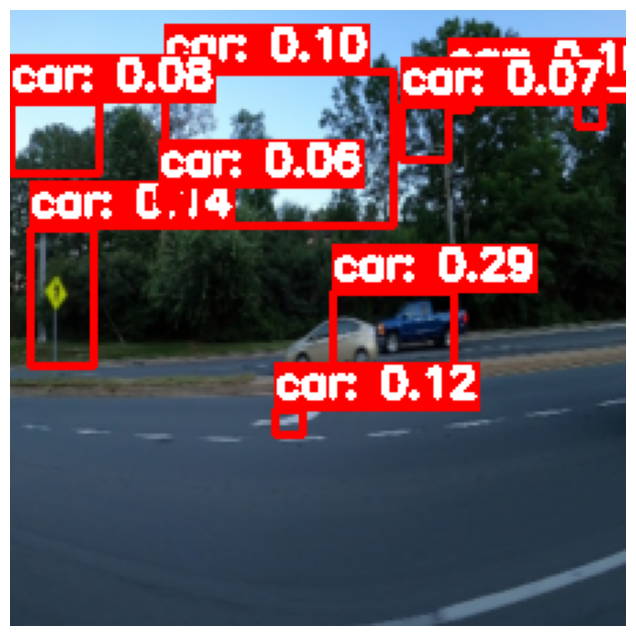

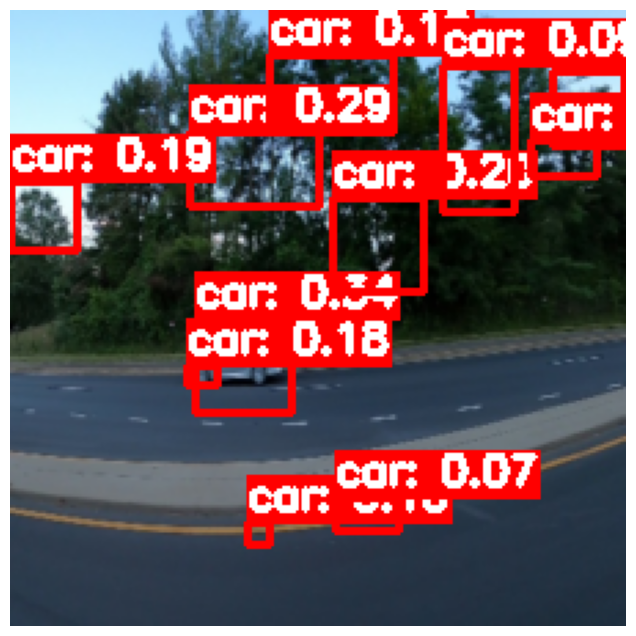

In [16]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    label_colors = {'car': (255, 0, 0)}  # Optional: custom colors
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        image_with_bbs = plot_bbs_confs_labels(images[ix].cpu().permute(1,2,0).numpy(), bbs, confs, labels, label_colors)

        # Display the image with bounding boxes
        plt.figure(figsize = (10,8))
        plt.imshow(image_with_bbs)
        plt.axis('off')
        plt.show()

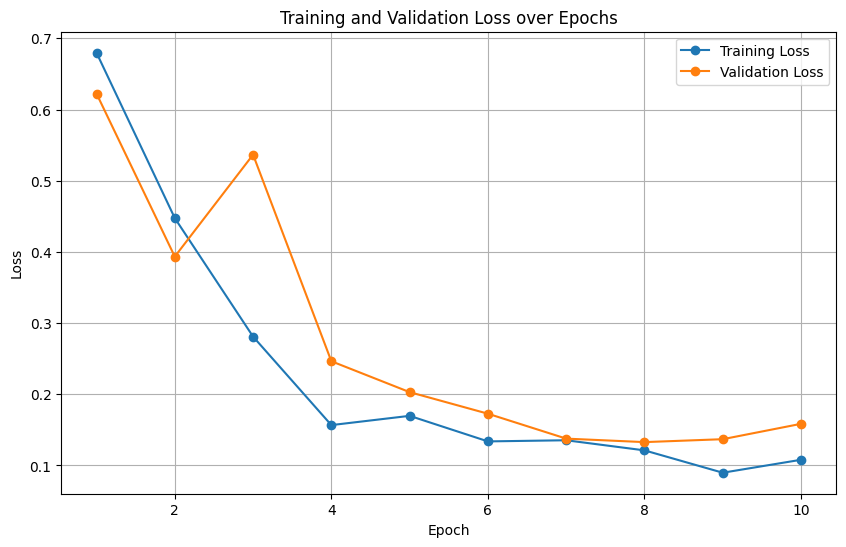

In [17]:
import matplotlib.pyplot as plt

# Values for the epochs and losses
epochs = list(range(1, 11))
train_loss = [0.6798, 0.4475, 0.2810, 0.1567, 0.1697, 0.1338, 0.1354, 0.1212, 0.0898, 0.1080]
val_loss = [0.6224, 0.3934, 0.5366, 0.2464, 0.2030, 0.1727, 0.1377, 0.1328, 0.1369, 0.1585]

# Plotting the loss values over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
